In [4]:
import numpy as np
import matplotlib.pyplot as plt
from linear_regression import LinearRegression
import pandas as pd
import os
import json
import datetime
import time
from misc.utils import MyUtils

In [5]:
# training config
max_degree = 1
epochs_list = [1000, 10_000, 100_000]
eta_list = [0.01, 0.001, 0.0001]
lam_list = [1] # TODO: implement this

# dataset config
normalize_neg1_pos1 = False
normalize_zero_one = True
num_samples = None # set to None for all samples

### Pre-Process Our Dataset

In [6]:
data_path = "./prog4/code_linear_regression/houseprice"

X_train = pd.read_csv(os.path.join(data_path, "x_train.csv")).to_numpy()[:num_samples]
y_train = pd.read_csv(os.path.join(data_path, "y_train.csv")).to_numpy()[:num_samples]
X_test = pd.read_csv(os.path.join(data_path, "x_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(data_path, "y_test.csv")).to_numpy()

if normalize_neg1_pos1:
    X_train = MyUtils.normalize_neg1_pos1(X_train)
    y_train = MyUtils.normalize_neg1_pos1(y_train)
    X_test = MyUtils.normalize_neg1_pos1(X_test)
    y_test = MyUtils.normalize_neg1_pos1(y_test)
    
elif normalize_zero_one:
    X_train = MyUtils.normalize_0_1(X_train)
    y_train = MyUtils.normalize_0_1(y_train)
    X_test = MyUtils.normalize_0_1(X_test)
    y_test = MyUtils.normalize_0_1(y_test)

### Run Metric Calculations

In [8]:
lr = LinearRegression()

results = [] # results will hold dict of (degree, epochs, eta, lam, train_mse, test_mse, y_hat)

for r in range(1, max_degree + 1):  # 1-based indexing
    print(f"degree {r}")
    
    for epoch_val in epochs_list:
        print(f"\tepochs {epoch_val}")
        
        for eta_val in eta_list:
            print(f"\t\teta {eta_val}")
            
            for lam_val in lam_list:
                print(f"\t\t\tlam {lam_val}")
                
                start = time.time()
                lr.fit(X=X_train, y=y_train, CF=False, epochs=epoch_val, eta=eta_val, degree=r, lam=lam_val)
                end = time.time()

                train_mse = lr.error(X=X_train, y=y_train)
                test_mse = lr.error(X=X_test, y=y_test)

                y_hat = lr.predict(X=X_test)

                result = {
                    "degree": r,
                    "epochs": epoch_val,
                    "eta": eta_val,
                    "lam": lam_val,
                    "train_mse": train_mse,
                    "test_mse": test_mse,
                    "y_hat": list(y_hat.flatten()), # json doesnt like the nd-array
                    "train_time": (end - start) # trainng time in seconds
                } 
                
                results.append(result)
                
                print(f"\t\t\tlam {lam_val} done;")
                
            print(f"\t\teta {eta_val} done;")
            
        print(f"\tepochs {epoch_val} done;")
        
    print(f"degree {r} done;")
        
assert len(results) == len(np.arange(max_degree)) * len(epochs_list) * len(eta_list) * len(lam_list) # debug
print(f"\nnumber of training runs: {len(results)}")

# store output
join_str = "-"
gd_output_filename = f"./output/{datetime.datetime.now()}_GD_degree-{max_degree}_epochs-{join_str.join([str(int) for int in epochs_list])}_eta-{join_str.join([str(int) for int in eta_list])}_lam-{join_str.join([str(int) for int in lam_list])}.json".replace(":", "-")
with open(gd_output_filename, "w") as file:
    json.dump(results, file)

degree 1
	epochs 1000
		eta 0.01
			lam 1
			lam 1 done;
		eta 0.01 done;
		eta 0.001
			lam 1
			lam 1 done;
		eta 0.001 done;
		eta 0.0001
			lam 1
			lam 1 done;
		eta 0.0001 done;
	epochs 1000 done;
	epochs 10000
		eta 0.01
			lam 1
			lam 1 done;
		eta 0.01 done;
		eta 0.001
			lam 1
			lam 1 done;
		eta 0.001 done;
		eta 0.0001
			lam 1
			lam 1 done;
		eta 0.0001 done;
	epochs 10000 done;
	epochs 100000
		eta 0.01
			lam 1
			lam 1 done;
		eta 0.01 done;
		eta 0.001
			lam 1
			lam 1 done;
		eta 0.001 done;
		eta 0.0001
			lam 1
			lam 1 done;
		eta 0.0001 done;
	epochs 100000 done;
degree 1 done;

number of training runs: 9


### Plotting MSE vs. Different Epochs Values

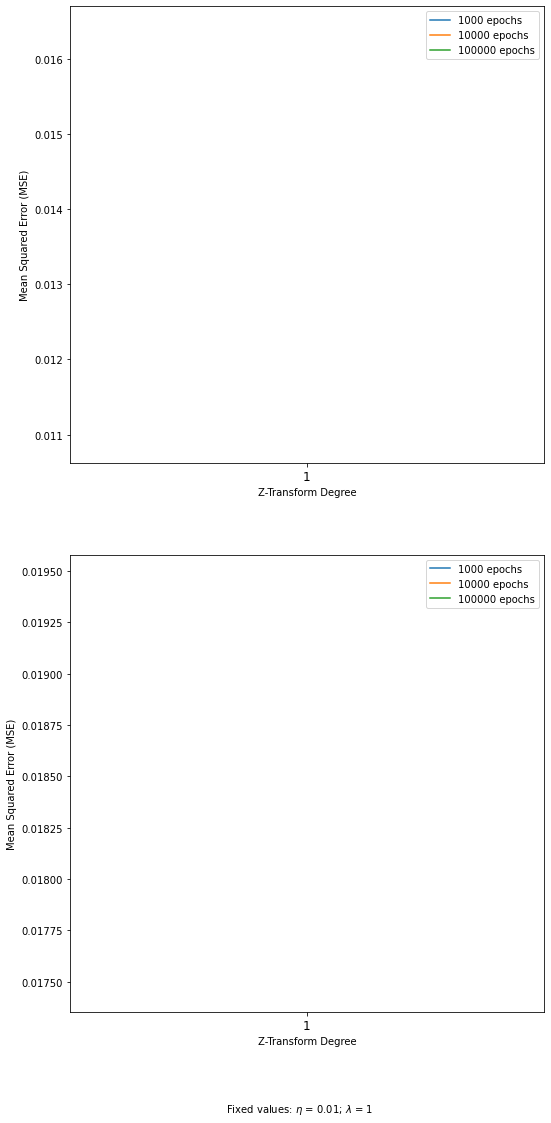

In [10]:
# load our data
with open(gd_output_filename, "r") as file:
    json_str = file.read()
gd_data = json.loads(json_str)

# we have to fix eta and lam
fixed_eta = eta_list[0]
fixed_lam = lam_list[0]

epochs_fig, epochs_axes = plt.subplots(2) # two subplots, one for train MSE, one for test MSE
train_ax = epochs_axes[0]
test_ax = epochs_axes[1]

x_axis = np.arange(1, max_degree + 1)

# x: degree, y: mse, plot one line for each epoch value (indicate in legend)
for i, epoch_val in enumerate(epochs_list):
    y_train_mse = []
    y_test_mse = []
    for r in x_axis: # x-axis is degree
        y_val = list(filter(lambda x: 
                            x["degree"] == r and 
                            x["epochs"] == epoch_val and 
                            x["eta"] == fixed_eta and 
                            x["lam"] == fixed_lam, 
                            gd_data))
        
        y_train_mse.append(y_val[0]["train_mse"]) 
        y_test_mse.append(y_val[0]["test_mse"]) 
        
    train_ax.plot(x_axis, y_train_mse, label=f"{epoch_val} epochs")
    test_ax.plot(x_axis, y_test_mse, label=f"{epoch_val} epochs")
    
    train_ax.legend()
    test_ax.legend()
    
    
# figure config    
epochs_fig.set_size_inches(8.5, 18.5)
epochs_fig.text(.5, .05, f"Fixed values: $\eta$ = {fixed_eta}; $\lambda$ = {fixed_lam}", ha='center')

# subplot config
for ax in epochs_axes:
#     ax.set_title(f"Number of Epochs vs. Training MSE")
    ax.set_ylabel("Mean Squared Error (MSE)")
    ax.set_xlabel("Z-Transform Degree")
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_axis, fontsize=12)  

plt.show()

In [11]:
# plot to examine the true y vs. predicted y for each degree
prediction_fig, pred_axes = plt.subplots(len(degree_x))

# figure config
prediction_fig.set_size_inches(18.5, 10.5)
prediction_fig.text(.5, .05, f"Epochs = {epochs}; $\eta$ = {eta}; $\lambda$ = {lam}", ha='center')

# x-vals for prediction_fig subplots
prediction_fig_x = np.arange(y_test.shape[0])

for i, (degree, prediction) in enumerate(zip(degree_x, prediction_y)):
    ax_pred = pred_axes[i]

    ax_pred.set_title(f"Degree: {degree}")
    ax_pred.set_ylabel("House price (y)")

    # plot truth and prediction
    ax_pred.plot(prediction_fig_x, y_test.flatten())
    ax_pred.plot(prediction_fig_x, prediction.flatten())
    ax_pred.legend(["truth", "prediction"])

plt.show()

NameError: name 'degree_x' is not defined

### Plotting Degree vs. Error

In [ ]:
error_fig, error_ax = plt.subplots(1)

error_ax.plot(degree_x, mse_val_y)
error_ax.plot(degree_x, mse_train_y)

# figure config
error_fig.set_size_inches(5.5, 10.5)
error_fig.text(.5, .05, f"Epochs = {epochs}; $\eta$ = {eta}; $\lambda$ = {lam}", ha='center')


# plot config
error_ax.set_title(f"Degree vs. Mean Squared Error (MSE)")
error_ax.set_ylabel("MSE")
error_ax.set_xlabel("Degree (r)")
error_ax.legend(["validation error", "training error"])
error_ax.set_xticks(degree_x)
error_ax.set_xticklabels(degree_x, fontsize=12)


plt.show()